<a href="https://colab.research.google.com/github/pietrodi/customer-churn-prediction/blob/main/notebooks/customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

As stated on [Wikipedia](https://en.wikipedia.org/wiki/Customer_attrition):
> Customer attrition, also known as customer churn [...] is the loss of clients or customers.
>
> Banks, telephone service companies, Internet service providers, pay TV companies, insurance firms, and alarm monitoring services, often use customer attrition analysis and customer attrition rates as one of their key business metrics (along with cash flow, EBITDA, etc.) because the cost of retaining an existing customer is far less than acquiring a new one. Companies from these sectors often have customer service branches which attempt to win back defecting clients, because recovered long-term customers can be worth much more to a company than newly recruited clients.
>
> [...] 
>
> Current organizations face therefore a huge challenge: to be able to anticipate to customers’ abandon in order to retain them on time, reducing this way costs and risks and gaining efficiency and competitivity.

Therefore, the objective of this notebook is to develop a machine learning model for a classification problem: predicting for a bank whether a customer will churn or not.

**Required Libraries**

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

# **The Dataset**

The modelling and training will be done on a dataset containing information about current and past customers of said bank and if they exited or not.

**Getting the data**

In [35]:
!wget https://raw.githubusercontent.com/pietrodi/customer-churn-prediction/main/data/customer-data.csv

--2022-10-15 15:58:23--  https://raw.githubusercontent.com/pietrodi/customer-churn-prediction/main/data/customer-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 674857 (659K) [text/plain]
Saving to: ‘customer-data.csv.1’

customer-data.csv.1 100%[===================>] 659.04K  --.-KB/s    in 0.03s   

2022-10-15 15:58:23 (18.8 MB/s) - ‘customer-data.csv.1’ saved [674857/674857]



**Loading the data**

In [36]:
df = pd.read_csv('customer-data.csv')

**First look at the data**

Below is a preview of the first 5 rows of the dataset:

In [37]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [38]:
print('Number of rows in the dataset:', df.shape[0])
print('Number of columns in the dataset:', df.shape[1])
print('Number of values in the dataset:', df.count().sum())
print('Number of missing values in the dataset: ', df.isna().sum().sum())
print('Number of duplicate rows in the dataset:', df.duplicated().sum())

Number of rows in the dataset: 10000
Number of columns in the dataset: 14
Number of values in the dataset: 140000
Number of missing values in the dataset:  0
Number of duplicate rows in the dataset: 0


*Notes:*

* The dataset has no missing values.
* The dataset has no duplicates.

**Quick look at the colums**

*Columns:*

> * `RowNumber` - Unique Id for each row in the dataset.
>
> * `CustomerId` - Unique Id for bank customer identification.
>
> * `Surname` - The last name of the customer.
>
> * `CreditScore` - The credit score of the customer.
>
> * `Geography` - The country of the customer.
>
> * `Gender` - Whether the customer is male or female.
>
> * `Age` - The age of the customer.
>
> * `Tenure` - The number of years for which the customer has been with the bank.
>
> * `Balance` - The bank balance of the customer.
>
> * `NumOfProducts` - Number of bank products the customer is utilising.
>
> * `HasCrCard` - Whether the customer holds a credit card with the bank or not.
>
> * `IsActiveMember` - Whether the customer is an active member with the bank or not.
>
> * `EstimatedSalary` - The estimated salary of the customer in dollars.
>
> * `Exited` - Whether the customer closed account with bank or not. This is the target.

In [39]:
print("The type of each column: ")
df.dtypes

The type of each column: 


RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [40]:
print("The number of unique values of each column: ")
df.nunique()

The number of unique values of each column: 


RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

*Notes:*

* There are 6 numerical columns, 4 categorical columns (excluding the target) and 3 qualitative columns.
* Even if `NumOfProducts` and `Tenure` are numbers, the two columns seem more fit to be categorical based on their low cardinality.

In [41]:
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
numerical = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
qualitative = ['RowNumber', 'CustomerId', 'Surname']

Below are some basic stats of the numerical colums of the dataset:

In [42]:
df[numerical].describe()

,CreditScore,Age,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,100090.239881
std,96.653299,10.487806,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,11.580000
25%,584.000000,32.000000,0.000000,51002.110000
50%,652.000000,37.000000,97198.540000,100193.915000
75%,718.000000,44.000000,127644.240000,149388.247500
max,850.000000,92.000000,250898.090000,199992.480000


# **Exploratory Data Analysis**

**Target Distribution**

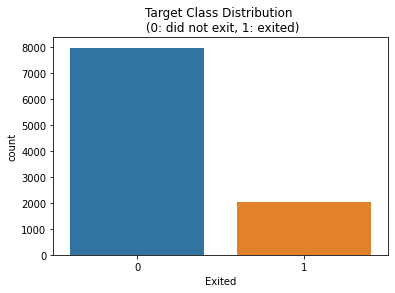

Number of minority class target variables:  2037
Proportion of minority class in target variable: 20.37%


In [43]:
sns.countplot(data = df, x = 'Exited')
plt.title("Target Class Distribution \n (0: did not exit, 1: exited)")
plt.show()

num_minority_target = (df['Exited'] == 1).sum()
print("Number of minority class target variables: ", num_minority_target)
print("Proportion of minority class in target variable: %.2f%%" % (num_minority_target / df.shape[0] * 100))

*Notes:*

* The target variable is moderately imbalanced. 
* The number of rows of the minority class is rather large.

*Insights:* 
* Leaving the dataset as it is will result in overfitting due to the imbalance of the target data. In order to solve this issue it's reasonable to apply undersampling since the number of rows in the resulting dataset (~4000) will still be acceptable.

I will now create an undersampled dataframe for the purpose of data analysis only.

In [44]:
# divide the datasets based on target variable
df_exited = df[df['Exited'] == 1]
df_not_exited = df[df['Exited'] == 0]

# rebalance based on dimension of minority class
num_exited = len(df_exited)
df_analysis = pd.concat([df_exited, df_not_exited[:num_exited]])

# shuffle the dataset
df_analysis = df_analysis.sample(frac = 1, random_state = 0).reset_index(drop = True)

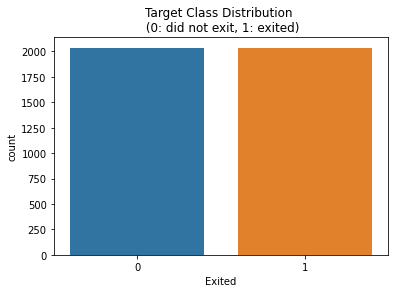

Number of minority class target variables:  2037
Proportion of minority class in target variable: 20.37%


In [45]:
sns.countplot(data = df_analysis, x = 'Exited')
plt.title("Target Class Distribution \n (0: did not exit, 1: exited)")
plt.show()

num_minority_target = (df_analysis['Exited'] == 1).sum()
print("Number of minority class target variables: ", num_minority_target)
print("Proportion of minority class in target variable: %.2f%%" % (num_minority_target / df.shape[0] * 100))

*Notes:*

* The target variable is now balaced.

While analyzing remaining features we have to keep in mind that simpler and fewer features make better models capable or generalizing better.

**Numerical Features**

Text(0.5, 1.0, 'Credit Score Distribution')

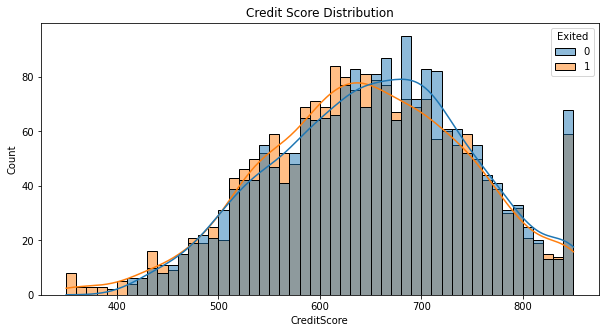

In [46]:
plt.figure(figsize = (10, 5))

sns.histplot(data = df_analysis, x = 'CreditScore', hue = 'Exited', kde = True, binwidth = 10)

plt.title('Credit Score Distribution')

*Notes:*

* The distribution of credit scores is not skewed.

*Insights:*
* There is no need to apply a log transformation to the feature.

Text(0.5, 1.0, 'Age Distribution')

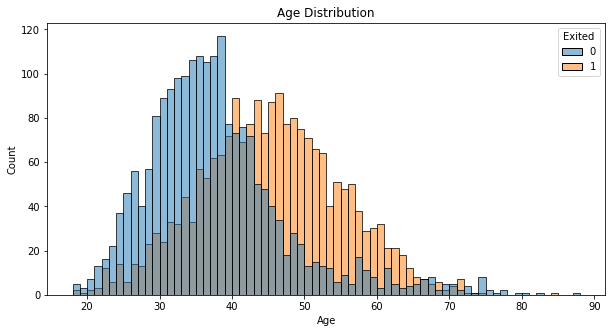

In [47]:
plt.figure(figsize = (10, 5))

sns.histplot(data = df_analysis, x = 'Age', hue = 'Exited', binwidth = 1)

plt.title('Age Distribution')

*Notes:*

* Customers aged 40 or more are much more likely to exit.
* Customers aged less than 40 are much more likely not to exit.
* The distribution of ages is skewed.

*Insights:*

* Age is an important feature in predicting exit.
* A log transformation needs to be applied to the Age feature.

Text(0.5, 1.0, 'Balance Distribution')

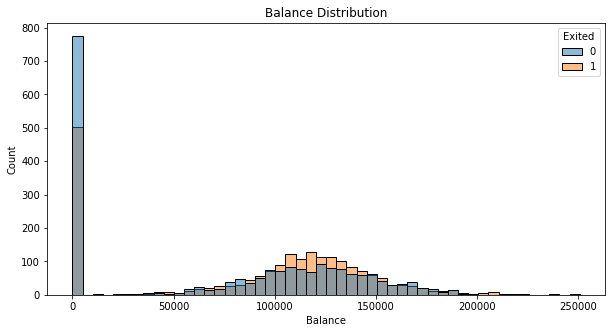

In [48]:
plt.figure(figsize = (10, 5))

sns.histplot(data = df_analysis, x = 'Balance', hue = 'Exited', bins = 50)

plt.title('Balance Distribution')

*Notes:*

* Most people have no balance.
* Customers with no balance are less likely to exit.
* The distribution of balances is skewed.

*Insights:*
* A new feature HasNoBalance can be created to keep track of whether a customer has no balance or not.
* A log transformation needs to be applied to the Balance feature.

Text(0.5, 1.0, 'Estimated Salary Distribution')

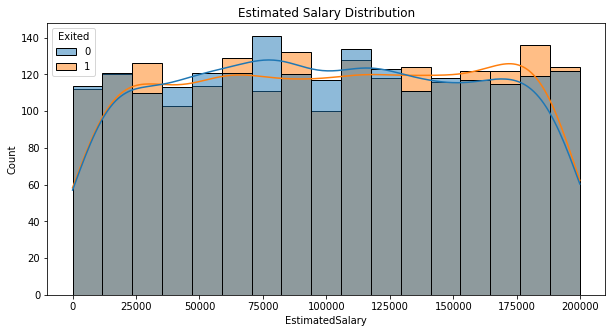

In [49]:
plt.figure(figsize = (10, 5))

sns.histplot(data = df_analysis, x = 'EstimatedSalary', hue = 'Exited', kde = True)

plt.title('Estimated Salary Distribution')

*Notes:*

* The esitmate salary does not seem to be a useful parameter in predicting exit.

*Insights:*
* EsimatedSalary can be dropped.

Text(0.5, 1.0, 'Correlation Matrix')

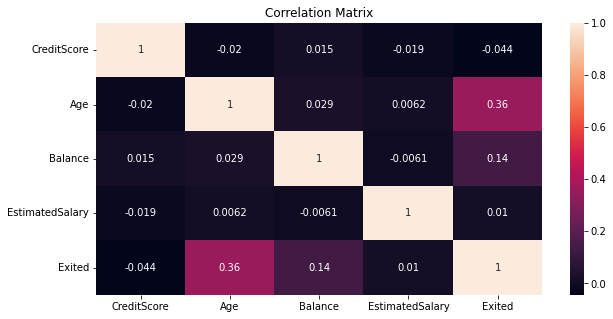

In [50]:
plt.figure(figsize=(10, 5))

sns.heatmap(df_analysis[[f'{feature}' for feature in numerical + ['Exited']]].corr(), annot=True)

plt.title("Correlation Matrix")

*Notes:*

* Age is confirmed to be the most important numerical feature in predicting exit.
* EstimatedSalary is confirmed to be not relevant, being the least relevant in predicting exit.

**Categorical Features**

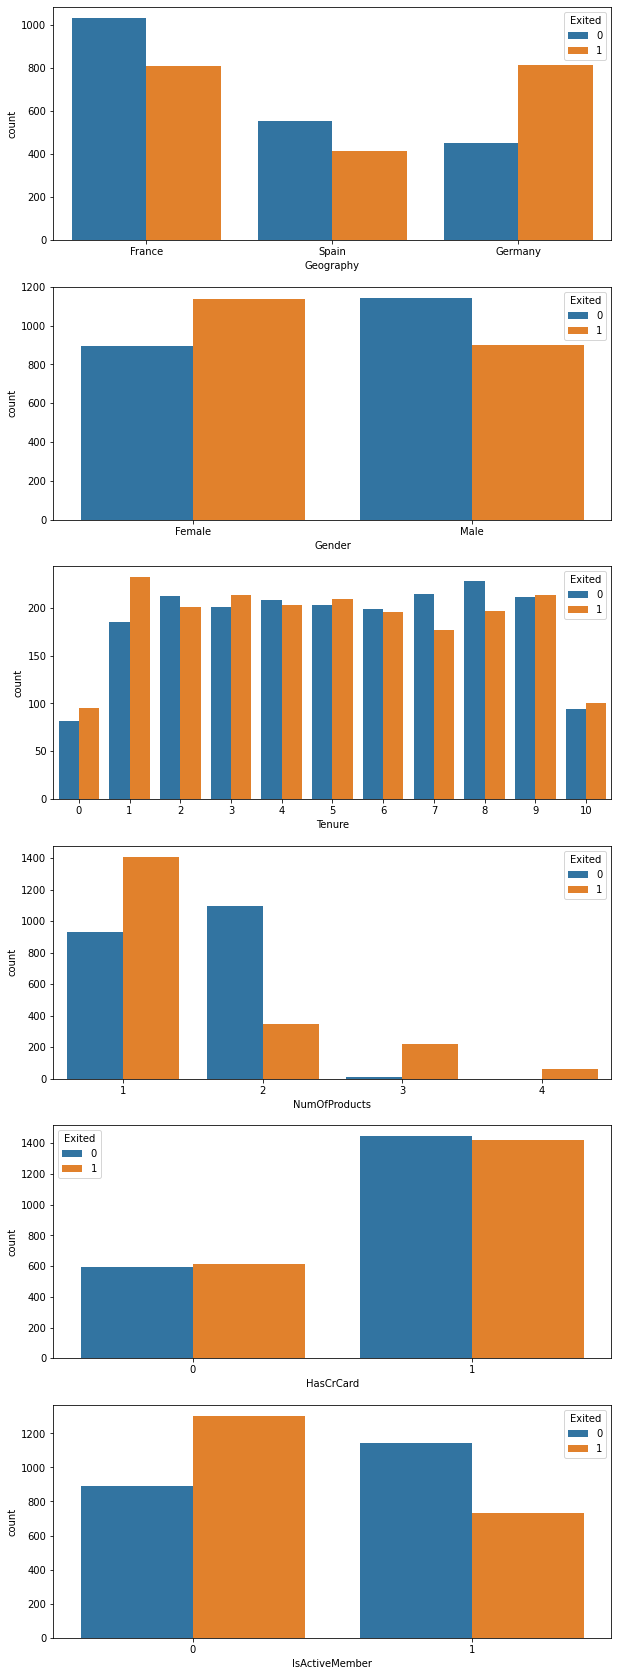

In [51]:
fig = plt.figure(figsize = (10, 30))

for i, feat in enumerate(categorical):
  ax = fig.add_subplot(6, 1, i + 1)
  sns.countplot(data = df_analysis, x = feat, hue = 'Exited')

*Notes:*

* HasCrCard does not seem to be a useful feature since its target split is more or less balanced.

*Insights:*
* HasCrCard can be dropped.

**Qualitative Features**

*Notes:*

* The available qualitative features are not relevant in solving the problem.

*Insights:*
* Qualitative features can be dropped.

# **Feature Engineering**

Based on the considerations made in the Exploratory Data Analysis section I will now introduce a new feature into the original dataset.

In [52]:
df['HasNoBalance'] = df['Balance'] == 0

Below is a visualization of the new categorical feature.

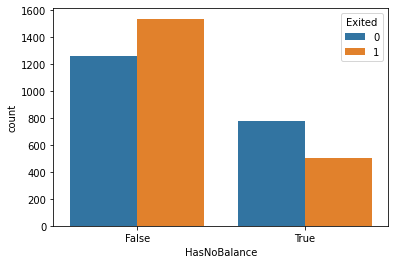

In [53]:
df_analysis['HasNoBalance'] = df_analysis['Balance'] == 0
sns.countplot(data = df_analysis, x = 'HasNoBalance', hue = 'Exited')

# **Preprocessing**

**Drop features**

In [54]:
features_to_drop = ['RowNumber', 'CustomerId', 'Surname', 'HasCrCard', 'EstimatedSalary']
df = df.drop(features_to_drop, axis = 1)

**Log transformation**

In [55]:
df['Balance'] = np.log1p(df['Balance'])
df['Age'] = np.log1p(df['Age'])

Below is a visualization of the transformed features.

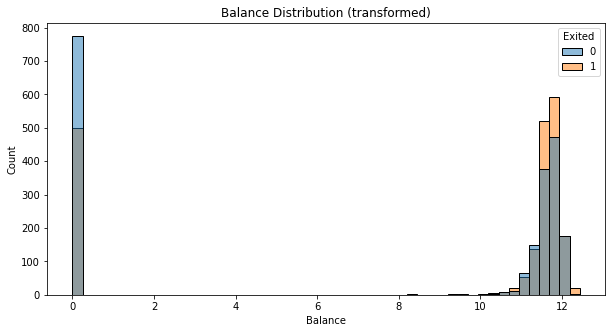

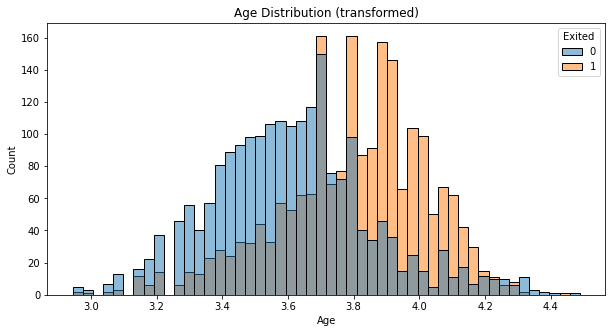

In [56]:
df_analysis['Balance'] = np.log1p(df_analysis['Balance'])
df_analysis['Age'] = np.log1p(df_analysis['Age'])
plt.figure(figsize = (10, 5))
sns.histplot(data = df_analysis, x = 'Balance', hue = 'Exited', bins = 50)
plt.title('Balance Distribution (transformed)')
plt.show()

plt.figure(figsize = (10, 5))
sns.histplot(data = df_analysis, x = 'Age', hue = 'Exited', bins = 50)
plt.title('Age Distribution (transformed)')
plt.show()

In [57]:
y = df['Exited'].values
df = df.drop('Exited', axis = 1)

**Encoding and Scaling**

In [58]:
numerical_features = ['Balance', 'CreditScore', 'Age']
categorical_features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 
                        'IsActiveMember', 'HasNoBalance']

In [59]:
numerical_transformer = Pipeline(steps = [('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse = False))])

ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
        remainder='passthrough')

X = ct.fit_transform(df)

print("Total number of features: ", X.shape[1])

Total number of features:  24


**Split into training and validation datasets**

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, train_size = 0.8, random_state = 0)
rus = RandomUnderSampler(random_state = 0)
X_train, y_train = rus.fit_resample(X_train, y_train)

# **Model Selection**

**Define classifiers**

Below are the classifiers that will be trained to solve the problem with their respective grids for parameter tuning.

In [61]:
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state = 0),
    "DecisionTree": DecisionTreeClassifier(random_state = 0),
    "RandomForest" : RandomForestClassifier(random_state = 0),
    "XGBoost" : XGBClassifier(random_state = 0, use_label_encoder = False, eval_metric = 'logloss'),
}

LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

DT_grid = {'max_depth': [4, 8, 12]}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
            'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
                'max_depth': [4, 8, 12],
                'learning_rate': [0.05, 0.1, 0.15]}

grids = {
    "LogisticRegression" : LR_grid,
    "DecisionTree": DT_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
}

**Train and evauate**

Below is the code for training and evaluating the classifiers.

In [62]:
best_params = {}
scores = {}
times = {}
for i, (name, classifier) in enumerate(classifiers.items()):
  start_time = time.time()
  gs = GridSearchCV(estimator = classifier, param_grid = grids[name], n_jobs = -1, cv = None)
  gs.fit(X_train, y_train)
  scores[name] = gs.score(X_val, y_val)
  stop_time = time.time()
  times[name] = stop_time - start_time
  best_params[name] = gs.best_params_
  print(f"Model: {name}, Training Time: {round(times[name], 2)}")

Model: LogisticRegression, Training Time: 2.82
Model: DecisionTree, Training Time: 0.19
Model: RandomForest, Training Time: 53.34
Model: XGBoost, Training Time: 103.44


In [63]:
scores

{'LogisticRegression': 0.76,
 'DecisionTree': 0.765,
 'RandomForest': 0.773,
 'XGBoost': 0.792}

The highest scoring classifiers are selected in order to make a final cross-validation to select the best model.

In [64]:
best_classifiers = {
    'RandomForest': RandomForestClassifier(**best_params['RandomForest'], random_state = 0),
    'XGBoost': XGBClassifier(**best_params['XGBoost'], random_state = 0)
}

In [65]:
for name, classifier in best_classifiers.items():
  model = make_pipeline (
      RandomUnderSampler(random_state = 0),
      classifier
  )

  cv_results = cross_validate (
      model, X, y, scoring = "balanced_accuracy",
      return_train_score = True, return_estimator = True,
      n_jobs = -1
  )

  print(
    f"Model {name}: "
    f"balanced accuracy mean +/- std. dev.: "
    f"{cv_results['test_score'].mean():.3f} +/- "
    f"{cv_results['test_score'].std():.3f}"
  )

Model RandomForest: balanced accuracy mean +/- std. dev.: 0.771 +/- 0.002
Model XGBoost: balanced accuracy mean +/- std. dev.: 0.777 +/- 0.004


The XGBoost model with the following parameters is the best classifier for solving this problem.

In [66]:
print("Params of the XGBoost model: ", best_params['XGBoost'])

Params of the XGBoost model:  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 50}
